In [1]:
import os
import cv2
import numpy as np

data_folder = "/public/home/xiaojx/age/age_estimation/data/utkface_aligned_cropped/UTKFace"
X_train = []
y_age_train = []

for filename in os.listdir(data_folder):
    if filename.endswith('.jpg'):
        # Extract the age
        age = filename[:-4].split('_')[0]
        # Load the image using OpenCV
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Append the image and age label to the lists
        X_train.append(image)
        y_age_train.append(int(age))

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_age_train = np.array(y_age_train)

# Print the shape of the arrays
print('Xtrain shape:', X_train.shape)
print('ytrain shape:', y_age_train.shape)

Xtrain shape: (23708, 200, 200, 3)
ytrain shape: (23708,)


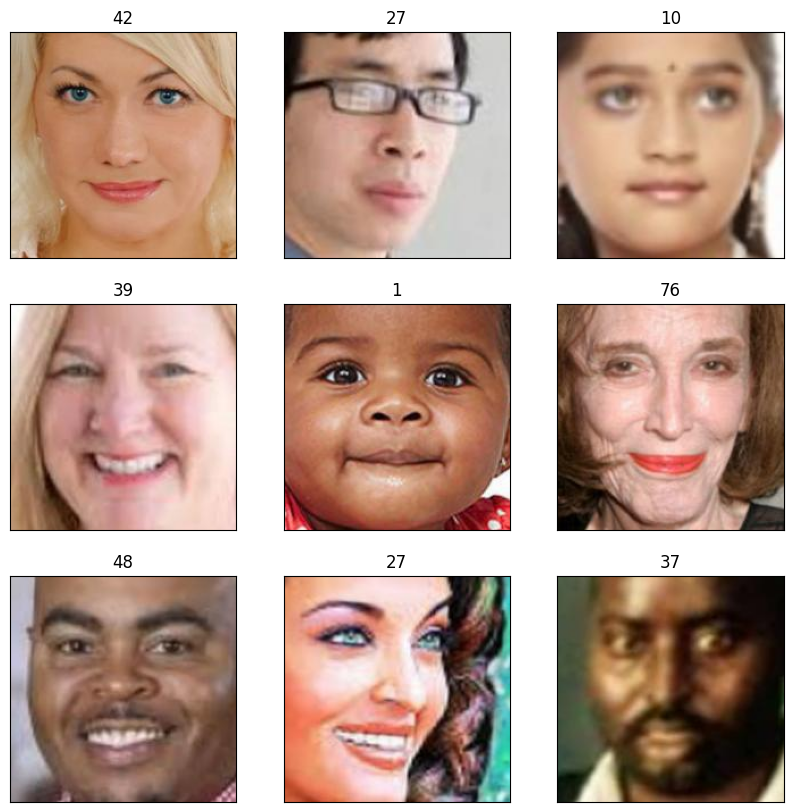

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
    x = np.random.randint(0, len(X_train))
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[x])
    plt.title(y_age_train[x])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [3]:
"""
create a new label named y_age_stage
Infant and Toddler: 0-3 years   class = 0
Preschooler and Kindergartener: 4-6 years  class = 1
child: 7-12 years class = 2
adolescent: 13-21 years class = 3
Adult in the prime : 22-37 years class = 4
Middle adult: 38-65 years class = 5
Elderly: 66-84 years class = 6
Oldest old: 85 years and older class = 7
"""
def map_age_stage(age):
    if age <= 3:
        return 0
    elif age <= 6:
        return 1
    elif age <= 12:
        return 2
    elif age <= 21:
        return 3
    elif age <= 37:
        return 4
    elif age <= 65:
        return 5
    elif age <= 84:
        return 6
    else:
        return 7

y_stage_train = np.array([map_age_stage(age) for age in y_age_train])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_stage_train, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4030, 200, 200, 3)
Train labels shape:  (4030,)
Validation data shape:  (2845, 200, 200, 3)
Validation labels shape:  (2845,)
Test data shape:  (712, 200, 200, 3)
Test labels shape:  (712,)


In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (4030, 120000)
Validation data shape:  (2845, 120000)
Test data shape:  (712, 120000)


In [6]:
class MultiClsPLA(object):
    
    def __init__(self, X_train, y_train, X_test, y_test, lr, num_epoch, weight_dimension, num_cls):
        super(MultiClsPLA, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.weight = self.initial_weight(weight_dimension, num_cls)
        self.sample_mean = np.mean(self.X_train, 0)
        self.sample_std = np.std(self.X_train, 0)
        self.num_epoch = num_epoch
        self.lr = lr
        self.total_acc_train = []
        self.total_acc_tst = []
          
    def initial_weight(self, weight_dimension, num_cls):
        weight = np.random.normal(0, 0.01, (weight_dimension, num_cls))
        return weight
        
    def data_preprocessing(self, data):
        norm_data = (data-self.sample_mean)/self.sample_std
        return norm_data
    
    def train_step(self, X_train, y_train, shuffle_idx):
        np.random.shuffle(shuffle_idx)
        X_train = X_train[shuffle_idx]
        y_train = y_train[shuffle_idx]
        for i in range(X_train.shape[0]):
            x = X_train[i]
            y = y_train[i]
            y_pred_parameter = np.dot(x, self.weight)
            y_pred = np.argmax(y_pred_parameter)
            if y_pred != y:
                self.weight[:, y] += self.lr * x
                self.weight[:, y_pred] -= self.lr * x
        train_acc = self.test_step(X_train, y_train)
        return train_acc
        
    def test_step(self, X_test, y_test):
        num_sample = X_test.shape[0]
        
        y_pred_parameter = np.dot(X_test, self.weight)
        y_pred = np.argmax(y_pred_parameter, axis=1)
        test_acc = np.sum(y_pred == y_test) / num_sample
        return test_acc
        
    def train(self):
           
        self.X_train = self.data_preprocessing(data=self.X_train)
        num_sample = self.X_train.shape[0]
        
        self.X_train = np.concatenate((self.X_train, np.ones((num_sample, 1))), axis=1)
        self.X_test = self.data_preprocessing(data=self.X_test)
        self.X_test = np.concatenate((self.X_test, np.ones((self.X_test.shape[0], 1))), axis=1)
                 
        shuffle_index = np.array(range(0, num_sample))
        for epoch in range(self.num_epoch):
            training_acc = self.train_step(X_train=self.X_train, y_train=self.y_train, shuffle_idx=shuffle_index)
            tst_acc = self.test_step(X_test=self.X_test,  y_test=self.y_test)
            self.total_acc_train.append(training_acc)
            self.total_acc_tst.append(tst_acc)
            print('epoch:', epoch, 'traing_acc:%.3f'%training_acc, 'tst_acc:%.3f'%tst_acc)
    
    def vis_acc_curve(self):
        train_acc = np.array(self.total_acc_train)
        tst_acc = np.array(self.total_acc_tst)
        plt.plot(train_acc)
        plt.plot(tst_acc)
        plt.legend(['train_acc', 'tst_acc'])
        plt.show()

epoch: 0 traing_acc:0.477 tst_acc:0.403
epoch: 1 traing_acc:0.530 tst_acc:0.437
epoch: 2 traing_acc:0.488 tst_acc:0.406
epoch: 3 traing_acc:0.589 tst_acc:0.463
epoch: 4 traing_acc:0.566 tst_acc:0.489
epoch: 5 traing_acc:0.619 tst_acc:0.454
epoch: 6 traing_acc:0.600 tst_acc:0.447
epoch: 7 traing_acc:0.633 tst_acc:0.455
epoch: 8 traing_acc:0.594 tst_acc:0.444
epoch: 9 traing_acc:0.641 tst_acc:0.444
epoch: 10 traing_acc:0.592 tst_acc:0.423
epoch: 11 traing_acc:0.655 tst_acc:0.486
epoch: 12 traing_acc:0.661 tst_acc:0.448
epoch: 13 traing_acc:0.618 tst_acc:0.414
epoch: 14 traing_acc:0.676 tst_acc:0.480
epoch: 15 traing_acc:0.656 tst_acc:0.442
epoch: 16 traing_acc:0.664 tst_acc:0.466
epoch: 17 traing_acc:0.719 tst_acc:0.461
epoch: 18 traing_acc:0.696 tst_acc:0.462
epoch: 19 traing_acc:0.689 tst_acc:0.463
epoch: 20 traing_acc:0.690 tst_acc:0.482
epoch: 21 traing_acc:0.724 tst_acc:0.468
epoch: 22 traing_acc:0.723 tst_acc:0.466
epoch: 23 traing_acc:0.660 tst_acc:0.510
epoch: 24 traing_acc:0.731

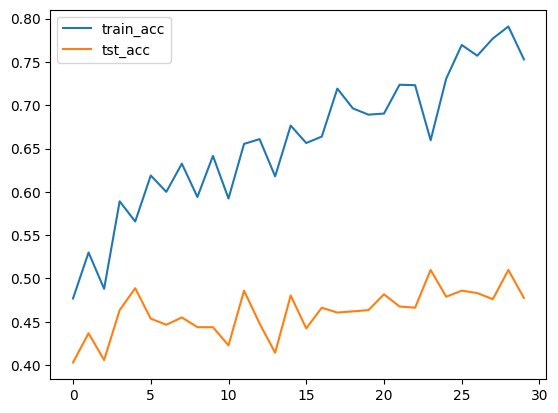

In [8]:
import random
np.random.seed(0)
random.seed(0)

model = MultiClsPLA(X_train, y_train, X_test, y_test, 0.03, 30, 120001, 8)
model.train()
model.vis_acc_curve()